In [2]:
!pip install tqdm
!pip install biosppy
!pip install wfdb
import os
import urllib.request as urllib2
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup as BSoup
import h5py
import wfdb as wf
import numpy as np
import pandas as pd
from glob import glob
from scipy import signal
from matplotlib import pyplot as plt
import tensorflow as tf
from biosppy.signals import ecg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.6 MB/s eta 0:00:00


In [3]:
def download_ltafdb():
    file_extensions = ['atr', 'dat', 'hea']
    base_url = 'https://www.physionet.org/physiobank/database/ltafdb/'

    # Save to proper data/ directory
    save_directory = 'data/ltafdb'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # File path format
    file_path_format = save_directory + '/{}.{}'

    # Find all interesting files on that site:
    soup = BSoup(urllib2.urlopen(base_url).read())

    # Find all links pointing to .dat files
    data_files = []
    for anchor in soup.find_all('a', href=True):
        href = anchor['href']
        if href.endswith('.dat'):
            data_files.append(href[:-4])


    download_url = base_url + '{}.{}'

    for data_id in data_files:
        for ext in file_extensions:
            web_path = download_url.format(data_id, ext)
            data_file = urllib2.urlopen(web_path)

            # Save locally
            file_path = file_path_format.format(data_id, ext)
            with open(file_path, 'wb') as output_file:
                output_file.write(data_file.read())

    print('Downloaded {} data files'.format(len(data_files)))


In [4]:
def get_ecg_records_paths():
    """ Get paths for data in data/ltafdb/ directory """
    # Download if doesn't exist
    if not os.path.isdir('data/ltafdb'):
        print('Downloading the ltafdb ecg database, please wait')
        download_ltafdb()
        print('Download finished')

    # There are 3 files for each record
    # *.atr is one of them
    record_paths = glob('data/ltafdb/*.atr')

    # Get rid of the extension
    record_paths = [path[:-4] for path in record_paths]
    record_paths.sort()

    return record_paths


In [6]:
# Получение записей ЭКГ
records_paths = get_ecg_records_paths()
for record_path in records_paths:
    path_parts = record_path.split('/')
    file_name = path_parts[-1]
    print('Загружаем файл: ', record_path)

    # Чтение данных
    record_data = wf.rdsamp(record_path)
    annotation = wf.rdann(record_path, 'atr')

    # Получение значений ЭКГ из файла
    data = record_data[0].transpose()

    # Создание классификаций на основе аннотаций
    # 0.0 = неопределенный
    # 1.0 = нормальный
    # 2.0 = аномальный
    rates = np.zeros_like(data[0], dtype='float')

    for idx, (beat_sample, beat_symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
        if beat_symbol == 'N':
            rates[beat_sample] = 1.0  # Нормальный
        else:
            rates[beat_sample] = 2.0  # Аномальный

    indices = np.arange(data[0].size, dtype='int')

    # Обработка каждого канала по отдельности (2 на каждый входной файл)
    for channel_id, channel in enumerate(data):
        chname = record_data[1].get('sig_name')[channel_id]

        beats = []
        for idx in range(len(annotation.symbol)):
            beat_start = annotation.sample[idx]
            beat_end = annotation.sample[idx + 1] if idx + 1 < len(annotation.symbol) else len(data[channel_id])
            beat_data = data[channel_id][beat_start:beat_end]

            if idx == 0 or idx == len(annotation.symbol) - 1:
                continue

            catval = rates[beat_start:beat_end].max()

            if catval == 0.0 or len(beat_data) > 187:
                continue

            # Нормальный удар теперь классифицируется как 0.0, а аномальный как 1.0.
            catval = catval - 1.0


            if len(beat_data) < 187:
                beat_data = np.pad(beat_data, (0, 187 - len(beat_data)), 'constant', constant_values=(0.0, 0.0))


            # Нормализация показаний для целей машинного обучения в диапазоне 0-1.
            min_val =  beat_data.min()
            max_val = beat_data.max()

            if max_val > 0:
                beat_data = (beat_data - min_val) / (max_val - min_val)

             # Добавление ответа
            beat_data = np.append(beat_data, catval)

            beats.append(beat_data)



        # Удаление первых и последних ударов и тех, у которых нет классификации.
        beats = [np.array(beat) for beat in beats]

        beats = np.asarray(beats, dtype="object")

        # Сохранение в CSV файл.
        savedata = np.array(list(beats[:]), dtype=float)
        outdir = 'data_ecg/'
        outfn = outdir + file_name + '_' + chname + '.csv'

        if not os.path.exists(outdir):
            os.makedirs(outdir)

        print('Создание: ', outfn)
        with open(outfn, "wb") as f:
            for beat in beats:
                np.savetxt(f, [beat], delimiter=",", fmt='%f')

Загружаем файл:  data/ltafdb/00
Создание:  data_ecg/00_ECG.csv
Создание:  data_ecg/00_ECG.csv
Загружаем файл:  data/ltafdb/01
Создание:  data_ecg/01_ECG.csv
Создание:  data_ecg/01_ECG.csv
Загружаем файл:  data/ltafdb/03
Создание:  data_ecg/03_ECG.csv
Создание:  data_ecg/03_ECG.csv
Загружаем файл:  data/ltafdb/05
Создание:  data_ecg/05_ECG.csv
Создание:  data_ecg/05_ECG.csv
Загружаем файл:  data/ltafdb/06
Создание:  data_ecg/06_ECG.csv
Создание:  data_ecg/06_ECG.csv
Загружаем файл:  data/ltafdb/07
Создание:  data_ecg/07_ECG.csv
Создание:  data_ecg/07_ECG.csv
Загружаем файл:  data/ltafdb/08
Создание:  data_ecg/08_ECG.csv
Создание:  data_ecg/08_ECG.csv
Загружаем файл:  data/ltafdb/10
Создание:  data_ecg/10_ECG.csv
Создание:  data_ecg/10_ECG.csv
Загружаем файл:  data/ltafdb/100
Создание:  data_ecg/100_ECG.csv
Создание:  data_ecg/100_ECG.csv
Загружаем файл:  data/ltafdb/101
Создание:  data_ecg/101_ECG.csv
Создание:  data_ecg/101_ECG.csv
Загружаем файл:  data/ltafdb/102
Создание:  data_ecg/1

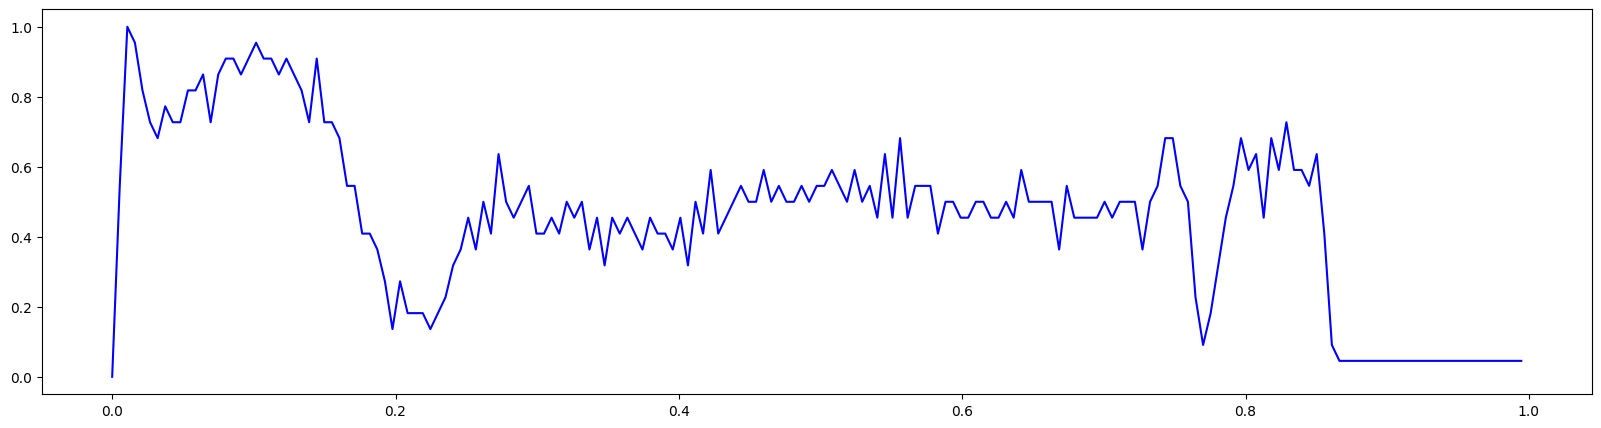

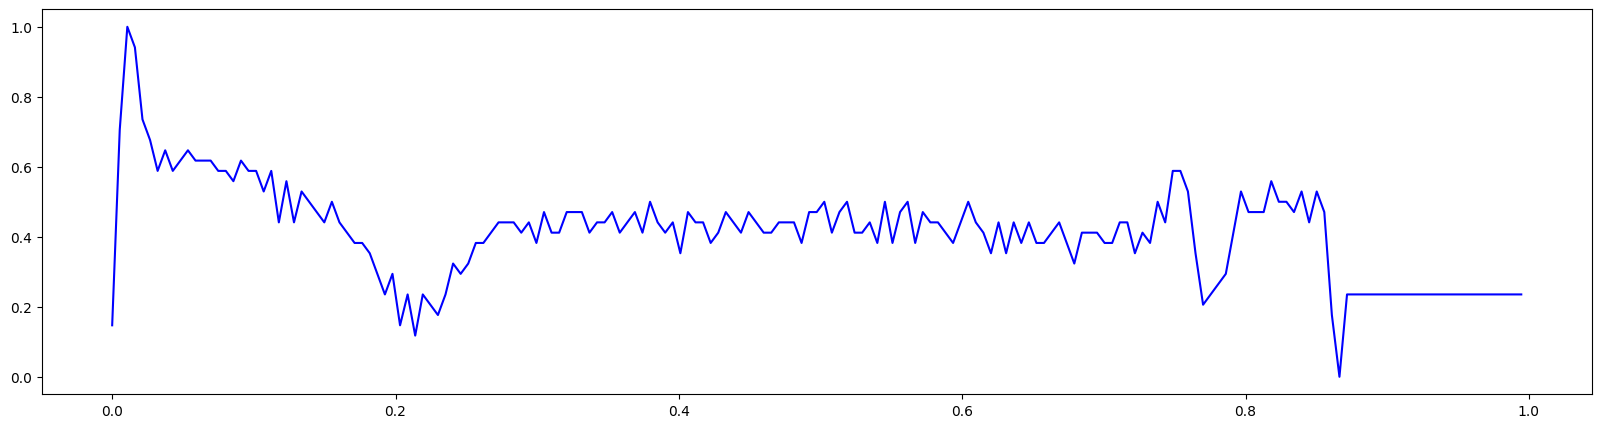

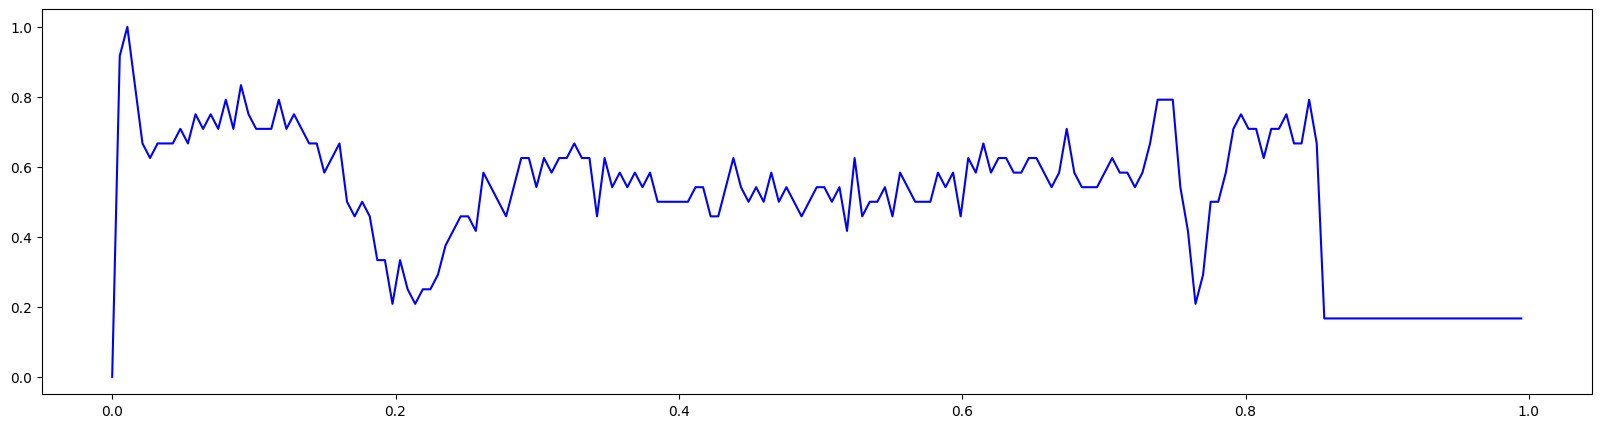

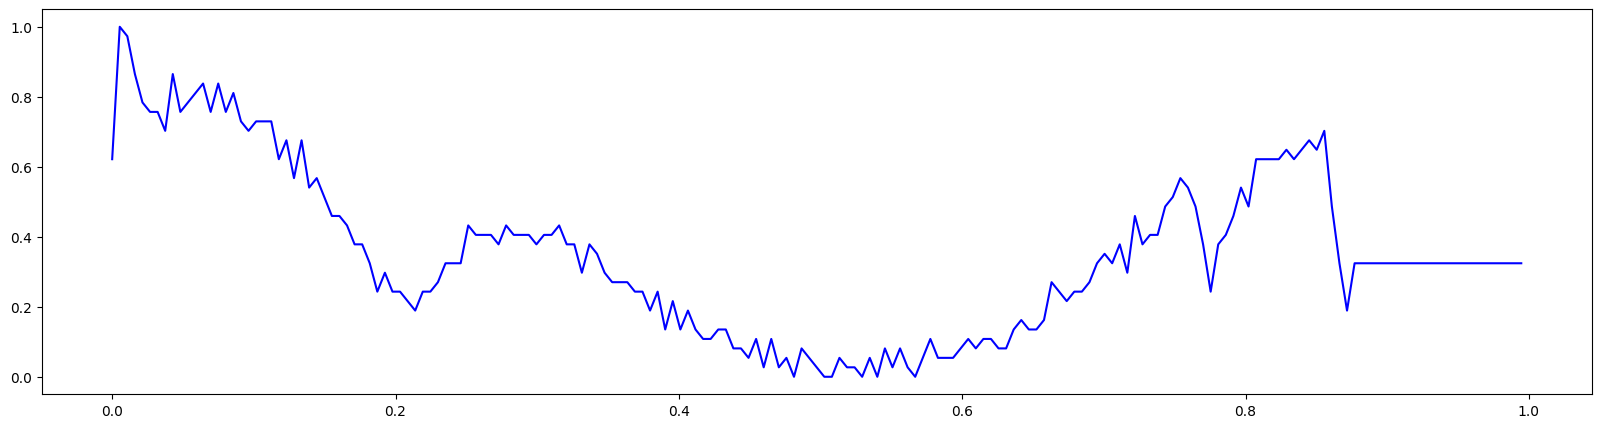

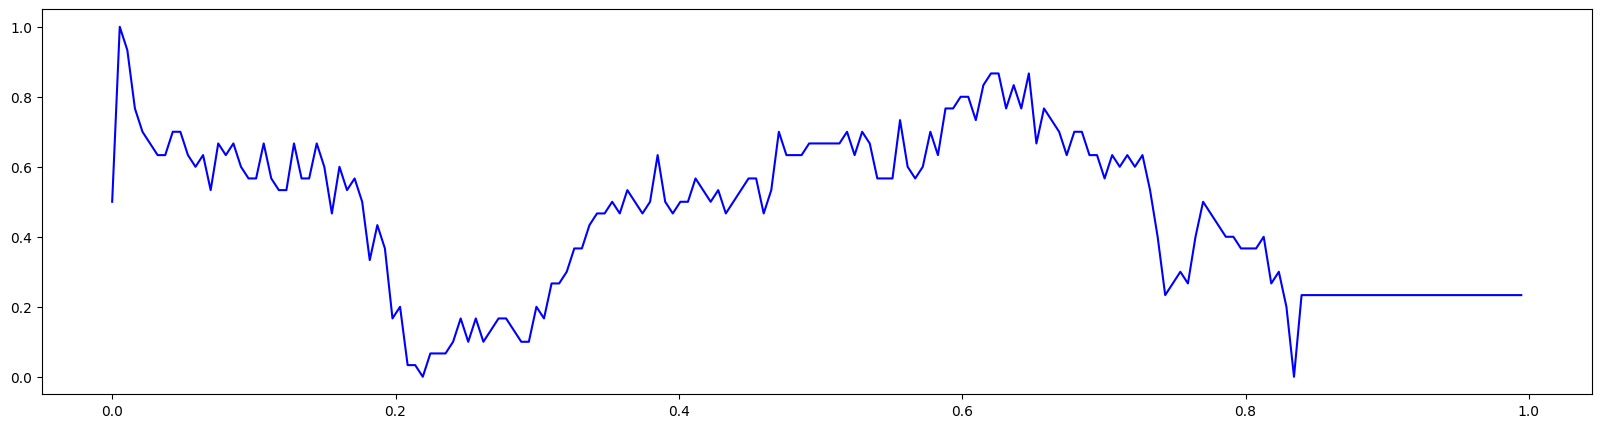

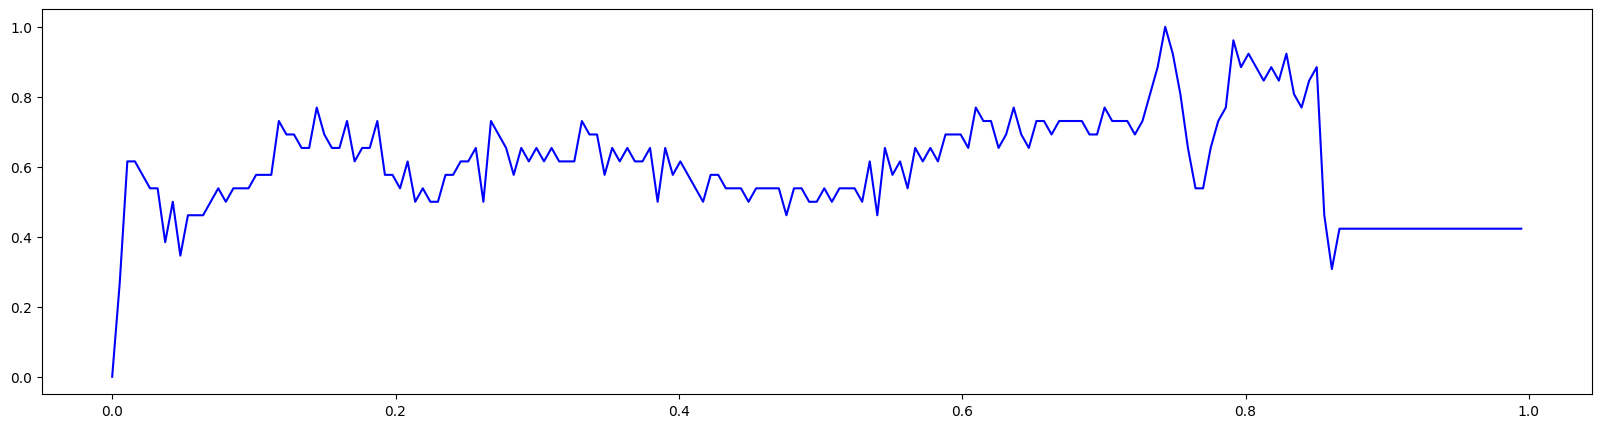

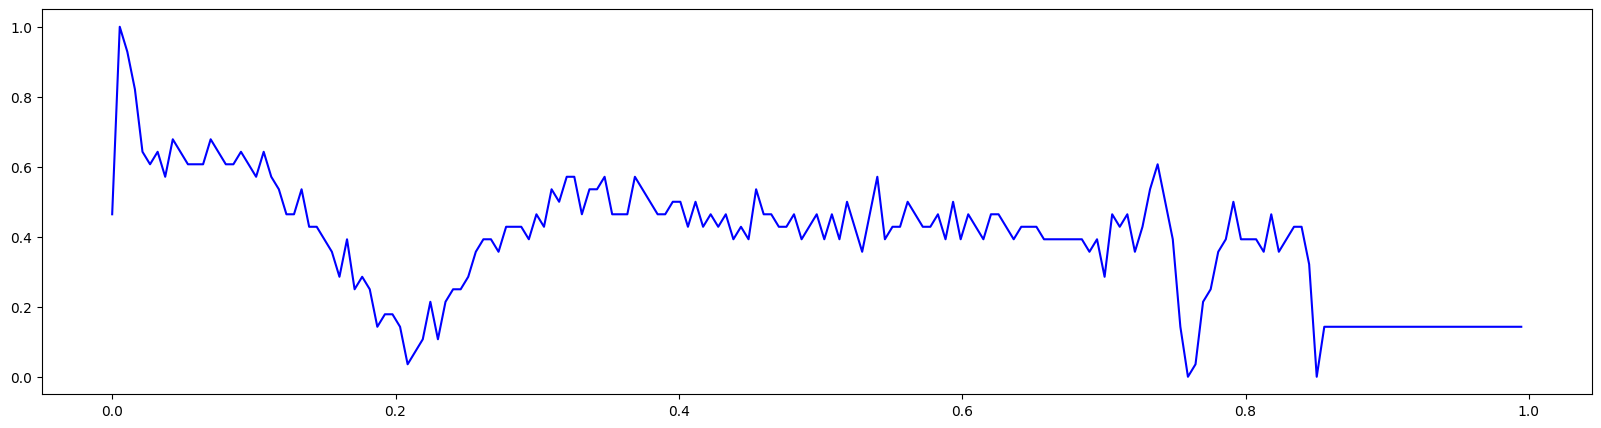

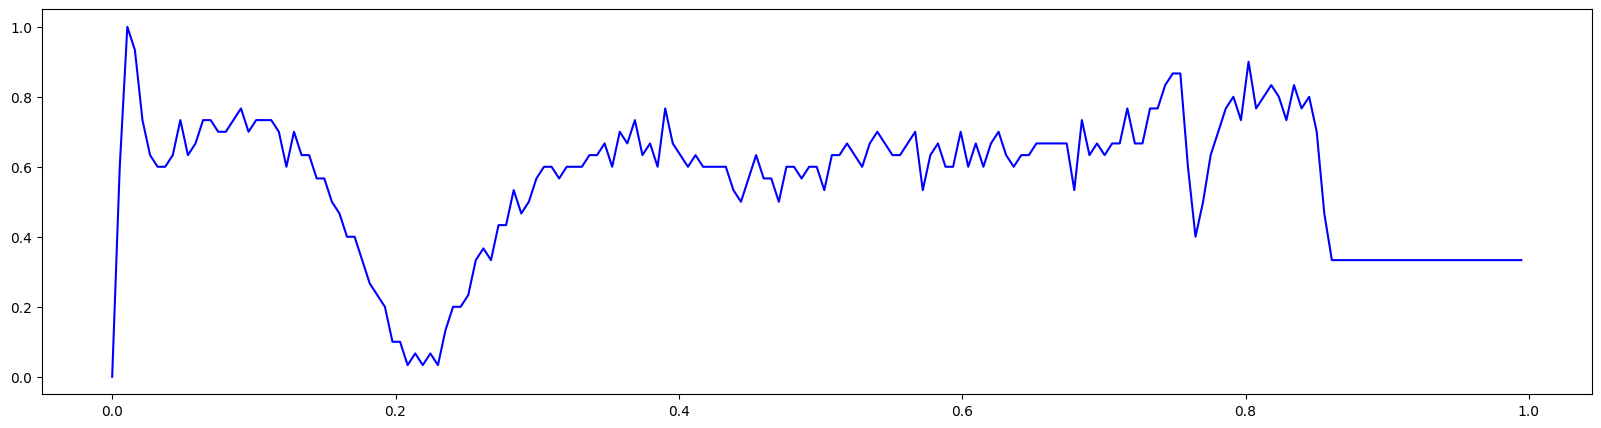

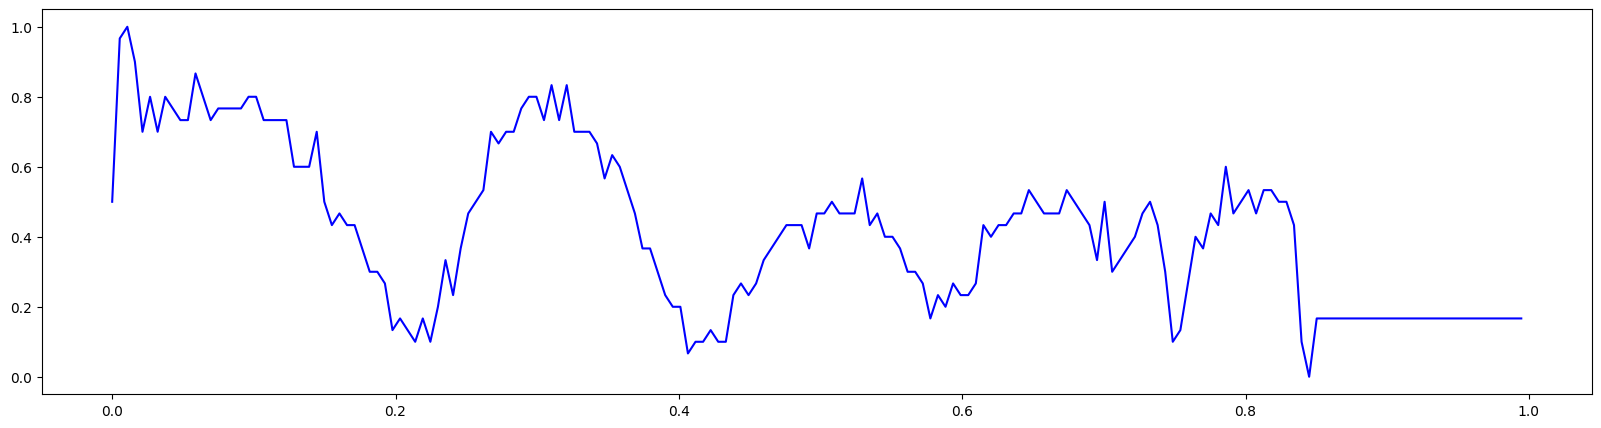

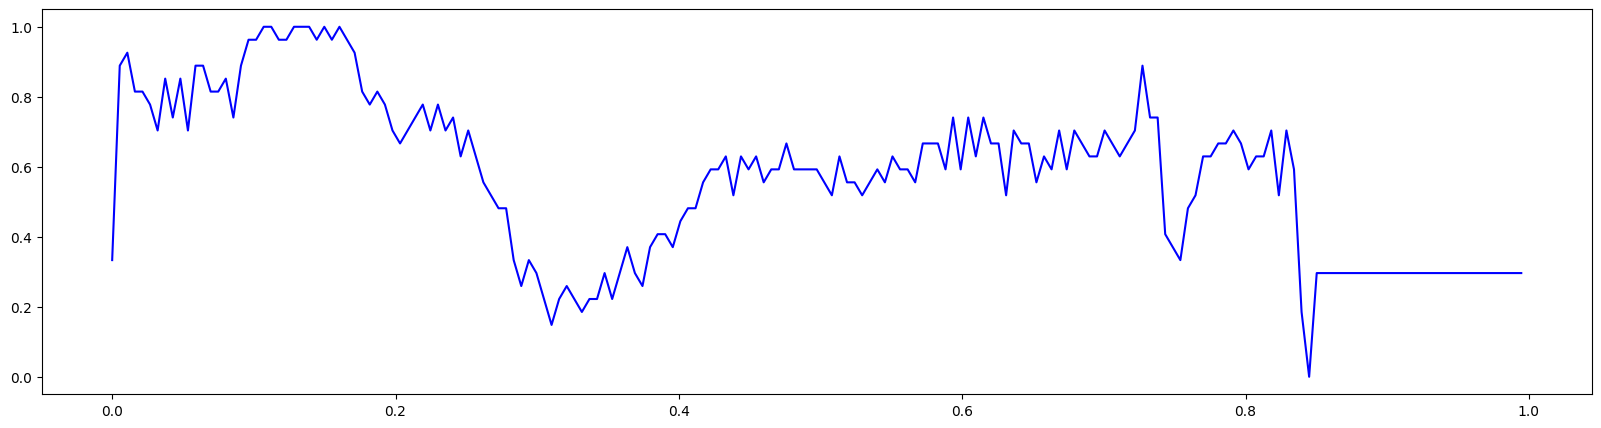

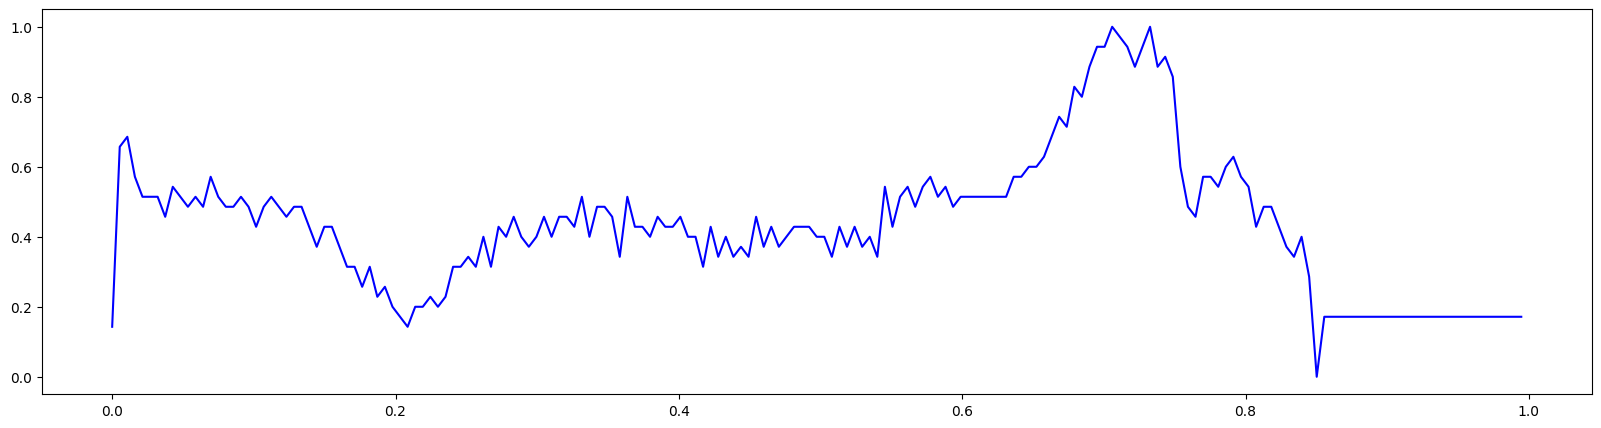

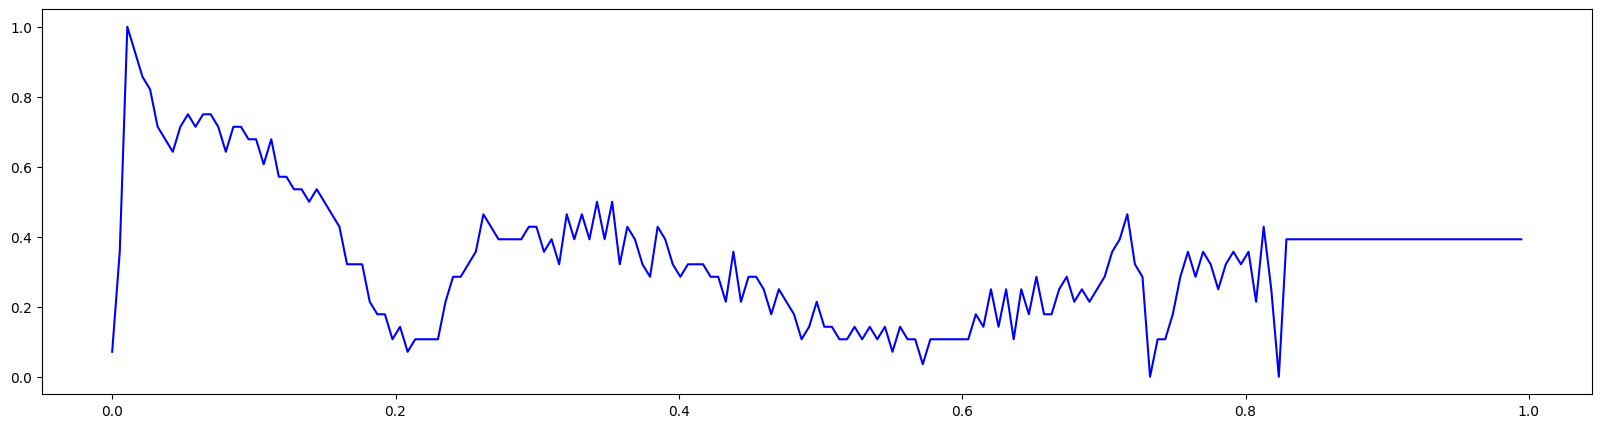

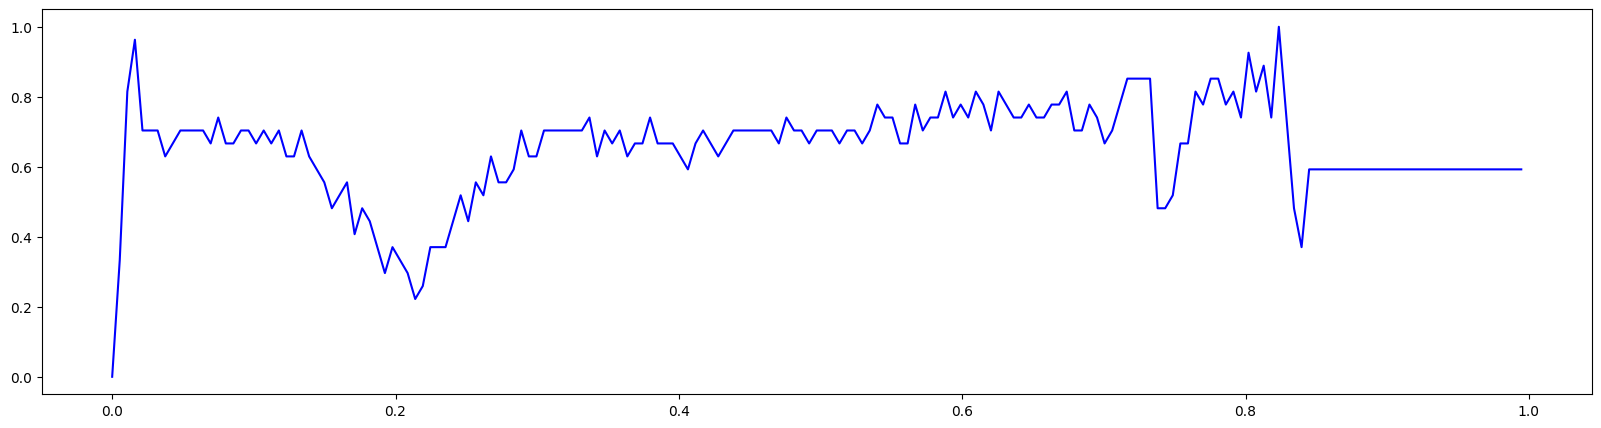

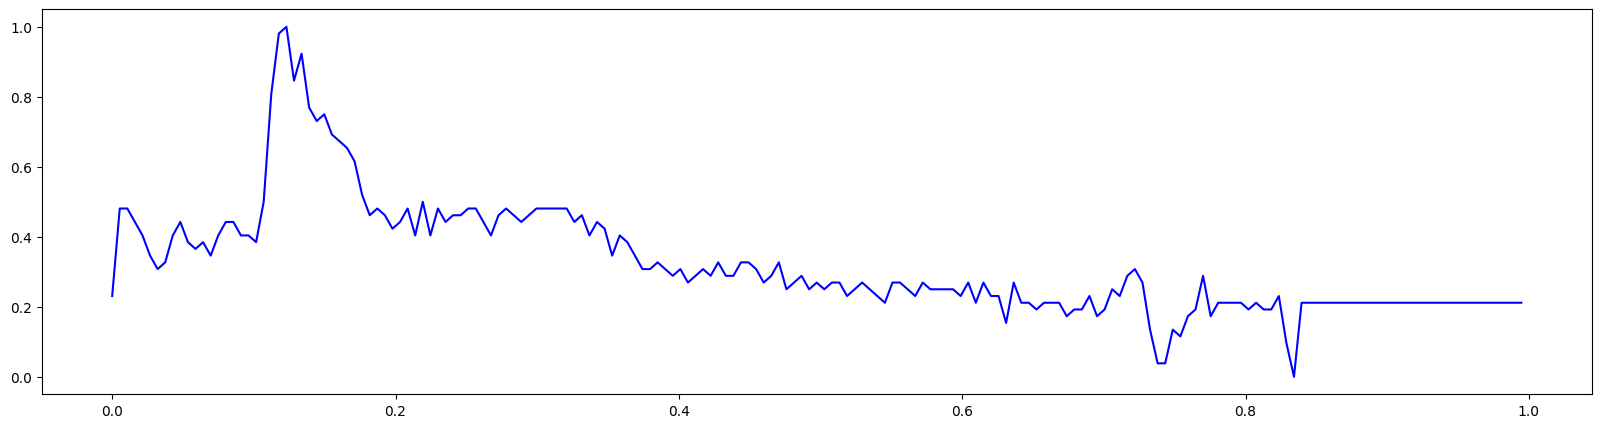

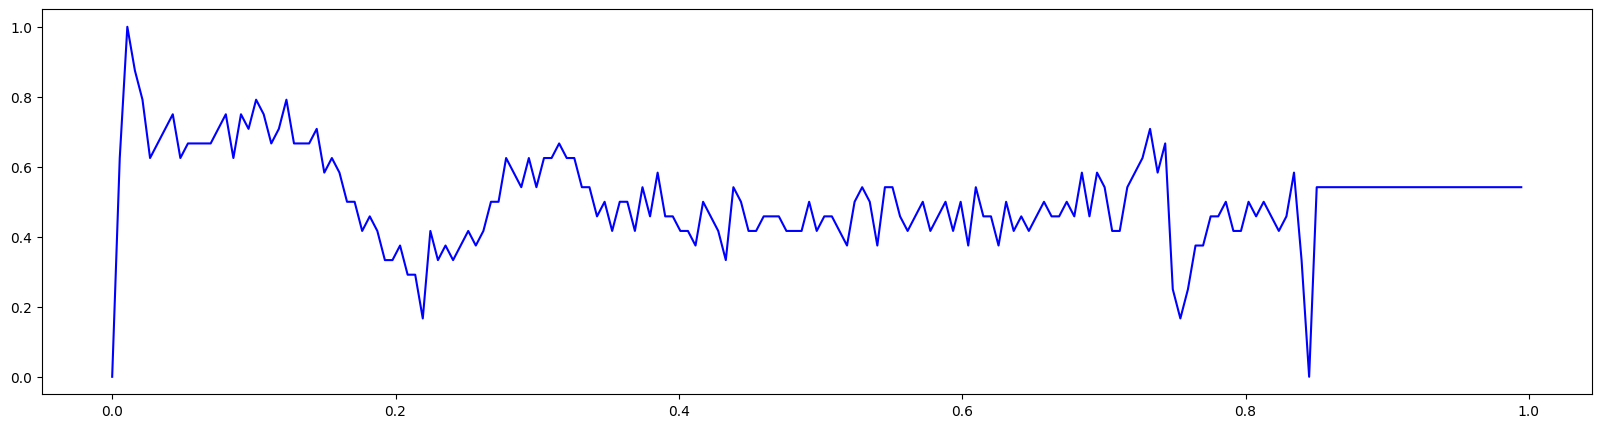

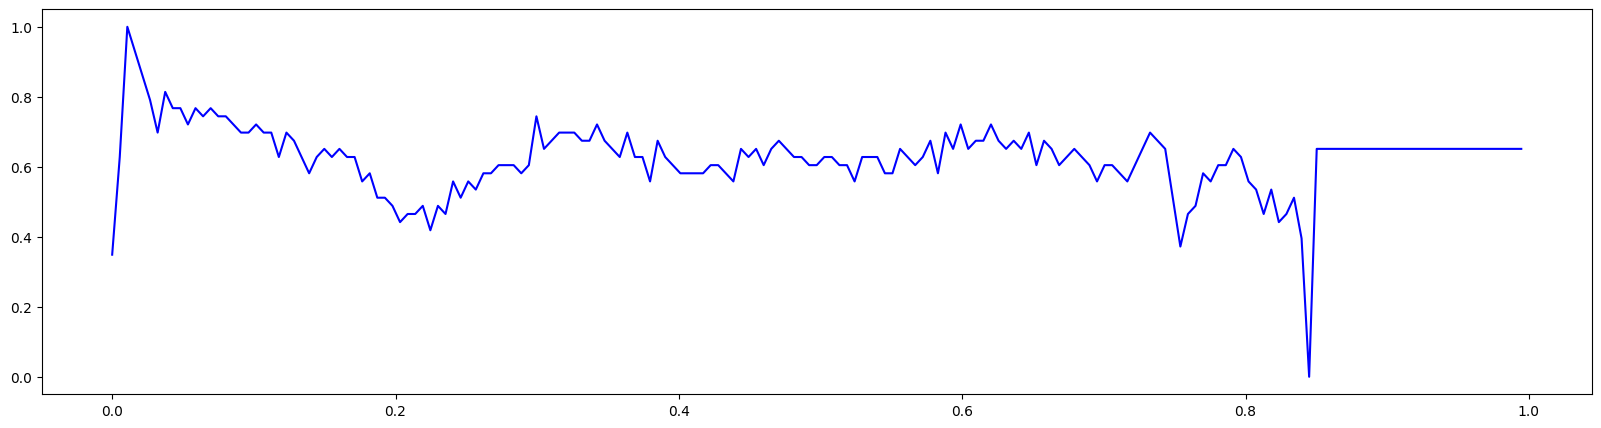

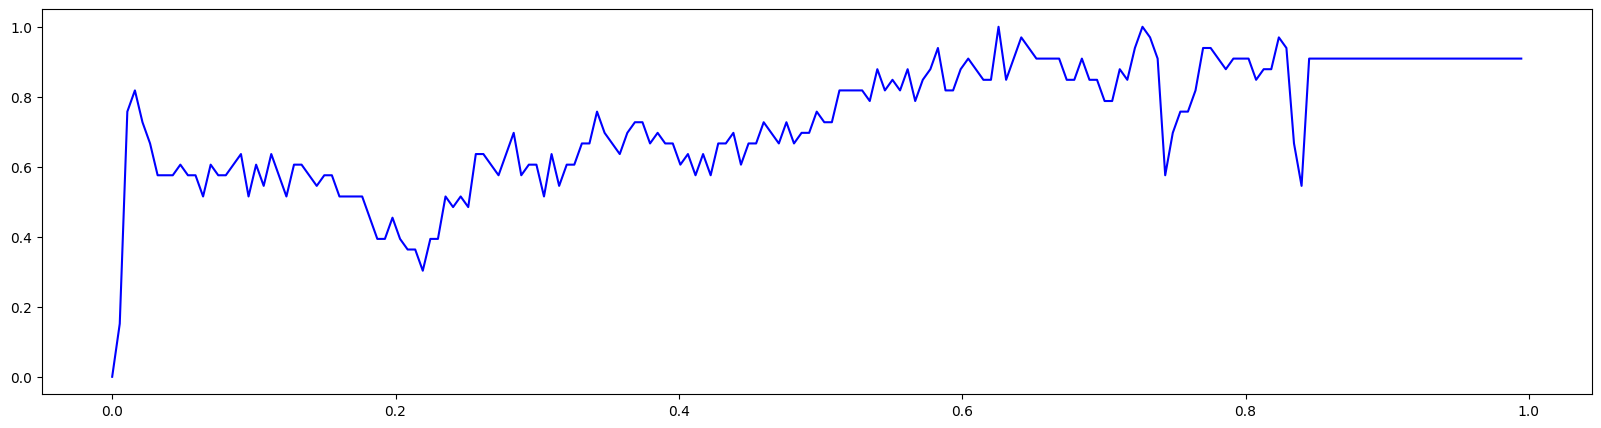

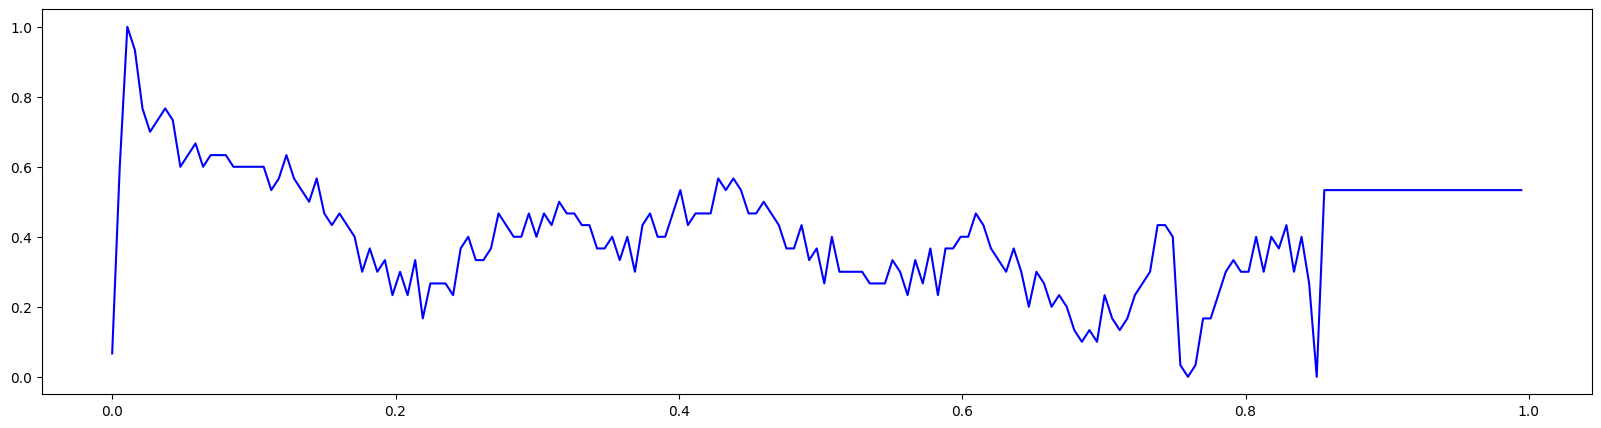

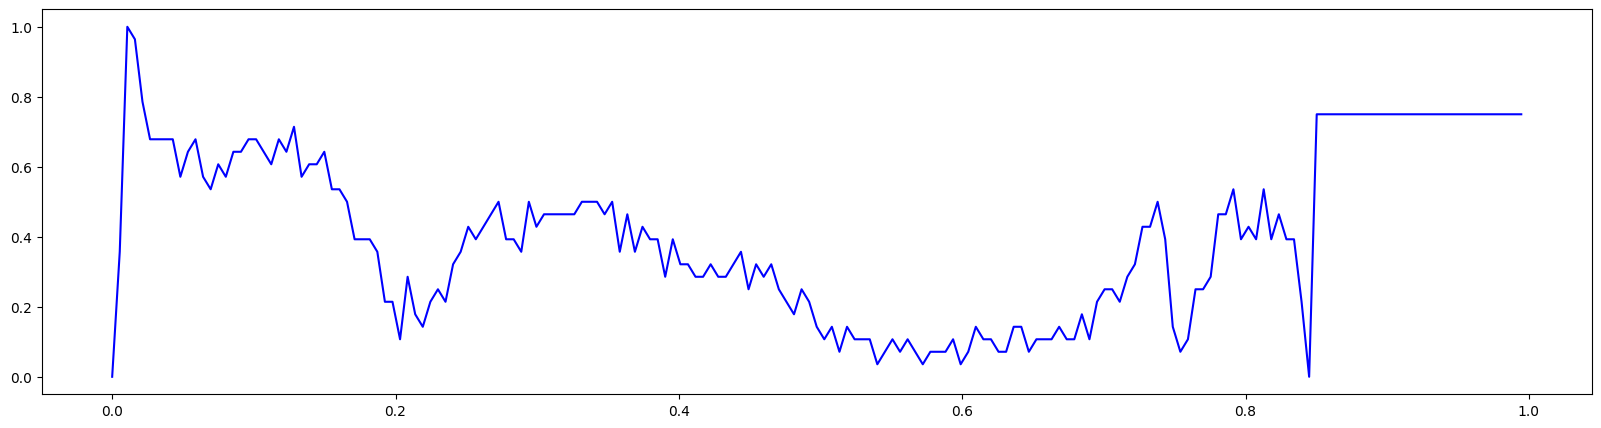

In [7]:
data = np.loadtxt('data_ecg/03_ECG.csv', delimiter=',')
for beatid in range(1, 3):
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    if (anno == 0.0):
        plt.plot(times, beat, 'b')
        pass
    else:
        plt.plot(times, beat, 'r')
        plt.xlabel('Time [s]')
        plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
        plt.show()

---

In [8]:
alldata = np.empty(shape=[0, 188])
paths = glob('data_ecg/*.csv')
for path in paths:
    print('Загружаем ', path)
    csvrows = np.loadtxt(path, delimiter=',')
    print(csvrows.shape)
    alldata = np.append(alldata, csvrows, axis=0)

Загружаем  data_ecg/104_ECG.csv
(84212, 188)
Загружаем  data_ecg/101_ECG.csv
(99483, 188)
Загружаем  data_ecg/03_ECG.csv
(84123, 188)
Загружаем  data_ecg/06_ECG.csv
(104904, 188)
Загружаем  data_ecg/07_ECG.csv
(109586, 188)
Загружаем  data_ecg/100_ECG.csv
(93115, 188)
Загружаем  data_ecg/10_ECG.csv
(106734, 188)
Загружаем  data_ecg/00_ECG.csv
(106335, 188)
Загружаем  data_ecg/102_ECG.csv
(114471, 188)
Загружаем  data_ecg/01_ECG.csv
(90052, 188)
Загружаем  data_ecg/103_ECG.csv
(155953, 188)
Загружаем  data_ecg/05_ECG.csv
(112958, 188)
Загружаем  data_ecg/08_ECG.csv
(108365, 188)


In [9]:
last_column = alldata[:, -1]

# Count occurrences of 0 and 1
count_0 = np.count_nonzero(last_column == 0)
count_1 = np.count_nonzero(last_column == 1)

print("Count of 0:", count_0)
print("Count of 1:", count_1)

Count of 0: 1289735
Count of 1: 80556


In [10]:
# Перемешиваем строки

np.random.shuffle(alldata)
totrows = len(alldata)
print(totrows)
trainrows = int((totrows * 3 / 5) + 0.5) # 60%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
validaterows = totrows - trainrows - testrows # 20%
mark1 = trainrows
mark2 = mark1 + testrows

1370291


In [11]:
with open('train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')

In [12]:
with open('test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

In [13]:
with open('validate.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark2:], delimiter=",", fmt='%f')

In [14]:
# Training dataset
df = pd.read_csv("train.csv", header=None)
x_train = df.values[:, :-1]
y_train = df.values[:, -1].astype(int)

# Validation dataset
df = pd.read_csv("validate.csv", header=None)
x_validate = df.values[:, :-1]
y_validate = df.values[:, -1].astype(int)

# Test dataset
df = pd.read_csv("test.csv", header=None)
x_test = df.values[:, :-1]
y_test = df.values[:, -1].astype(int)

In [15]:
#Проводим undersampling: делаем присутсвие наибольшего по частоте класса таким же, как и наименьшего

train_df = pd.DataFrame(data=np.concatenate((x_train, y_train.reshape(-1, 1)), axis=1))

class_0 = train_df[train_df[train_df.columns[-1]] == 0]
class_1 = train_df[train_df[train_df.columns[-1]] == 1]

num_samples = min(len(class_0), len(class_1))

class_0_sampled = class_0.sample(n=num_samples, random_state=42)

balanced_train_df = pd.concat([class_0_sampled, class_1], ignore_index=True)

balanced_train_df = balanced_train_df.sample(frac=1, random_state=42)

x_train_balanced = balanced_train_df.iloc[:, :-1].values
y_train_balanced = balanced_train_df.iloc[:, -1].astype(int).values


In [16]:
# Проверяем сбалансированность классов
unique_values, counts = np.unique(y_train_balanced, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 48448
Value: 1, Count: 48448


In [29]:
feature_columns = [tf.feature_column.numeric_column('beat', shape=[187])]

estimator = tf.estimator.DNNClassifier(
   feature_columns=feature_columns,
   hidden_units=[256, 64, 16],
   optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
   n_classes=2,
   dropout=0.1,
   model_dir='ecg_model'
)

input_fn_train = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x={'beat': x_train_balanced},
    y=y_train_balanced,
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

In [ ]:
estimator.train(input_fn=input_fn_train, steps=300000)

Instructions for updating:
Use standard file utilities to get mtimes.


---

In [20]:
input_fn_validate = tf.compat.v1.estimator.inputs.numpy_input_fn(
    x={'beat': x_validate},
    y=y_validate,
    num_epochs=1,
    shuffle=False
)

In [21]:
accuracy_score = estimator.evaluate(input_fn=input_fn_validate)
print('\nTest Accuracy: {0:f}%\n'.format(accuracy_score['accuracy']*100))

Instructions for updating:
Use tf.keras instead.



Test Accuracy: 92.581135%



---

In [22]:
input_fn_test = tf.compat.v1.estimator.inputs.numpy_input_fn(
 x={'beat': x_test},
 y=y_test,
 num_epochs=1,
 shuffle=False
)

In [23]:
predictions = estimator.predict(input_fn=input_fn_test)

In [ ]:
totvals = 0
totwrong = 0

for prediction, expected in zip(predictions, y_test):
    totvals = totvals + 1
    catpred = prediction['class_ids'][0]
    certainty = prediction['probabilities'][catpred] * 100
    if (expected != catpred):
        totwrong = totwrong + 1
        #print (prediction)
        print('Real: ', expected, ', pred: ', catpred, ', cert: ', certainty)

print('Accuracy: ', ((totvals - totwrong) * 100.0 / totvals))
print('Wrong: ', totwrong, ' out of ', totvals)

In [26]:
predictions = estimator.predict(input_fn=input_fn_test)
# Переменные для подсчета ошибок первого и второго рода
false_positives = 0  # Ошибка первого рода
false_negatives = 0  # Ошибка второго рода

# Общее количество аномальных объектов в тестовом наборе данных
total_anomalies = sum(y_test)

# Общее количество нормальных объектов в тестовом наборе данных
total_normals = len(y_test) - total_anomalies

# Расчет ошибок первого и второго рода
for prediction, expected in zip(predictions, y_test):
    catpred = prediction['class_ids'][0]
    # Если ожидаемое значение не совпадает с предсказанным
    if expected != catpred:
        # Если ожидается аномалия, но предсказано нормальное состояние
        if expected == 1:
            false_negatives += 1  # Увеличиваем ошибку второго рода
        # Если ожидается нормальное состояние, но предсказана аномалия
        else:
            false_positives += 1  # Увеличиваем ошибку первого рода
print(f"{false_positives=}, {total_normals=}")
# Расчет вероятности ошибок первого и второго рода
FPR = false_positives *1.0 / total_normals  # Вероятность ошибки первого рода (FPR)
FNR = false_negatives *1.0 / total_anomalies  # Вероятность ошибки второго рода (FNR)

# Вывод результатов
print('Вероятность ошибки первого рода / False Positive Rate (FPR):', FPR)
print('Вероятность ошибки второго рода / False Negative Rate (FNR):', FNR)


false_positives=18057, total_normals=258012
Вероятность ошибки первого рода / False Positive Rate (FPR): 0.06998511697130366
Вероятность ошибки второго рода / False Negative Rate (FNR): 0.14065810793967343


In [27]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = []
predictions = estimator.predict(input_fn=input_fn_validate)
for prediction in predictions:
    pred_class = prediction['class_ids'][0]
    y_pred.append(pred_class)


y_pred = np.array(y_pred)
# Рассчитываем classification report и accuracy
classification_rep = classification_report(y_validate, y_pred)
accuracy = accuracy_score(y_validate, y_pred)

# Выводим classification report и accuracy
print("\nClassification Report:")
print(classification_rep)
print("Accuracy:", accuracy)



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    257996
           1       0.43      0.86      0.58     16062

    accuracy                           0.93    274058
   macro avg       0.71      0.89      0.77    274058
weighted avg       0.96      0.93      0.94    274058

Accuracy: 0.9258113246101191


In [ ]:
feature_placeholders = { 'beat': tf.placeholder(dtype=tf.float32, shape=(187,)) }
serving_input_receiver_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_placeholders)
export_dir = estimator.export_savedmodel('ecg_serving', serving_input_receiver_fn, strip_default_attrs=True)